# Beauty Regressor


# Setup and Helpers

In [1]:
# Imports
%run ../src/utils/helpers.py

from collections import defaultdict
import requests
import boto3
import tempfile
import wget

import numpy as np
import pandas as pd
import random

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from IPython.display import Image, display, clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Initialization
s3_client = boto3.client('s3')
s3 = boto3.resource('s3')
s3_resource = boto3.resource('s3')
bucket_name = 'eye-of-the-needle'
bucket = s3.Bucket(bucket_name)

Records loaded. 1580 out of 3213 photos have been labeled stunning.

Displaying images scored 0:
['2016/03/06/2016_0306_190000/thumbnail.jpg']


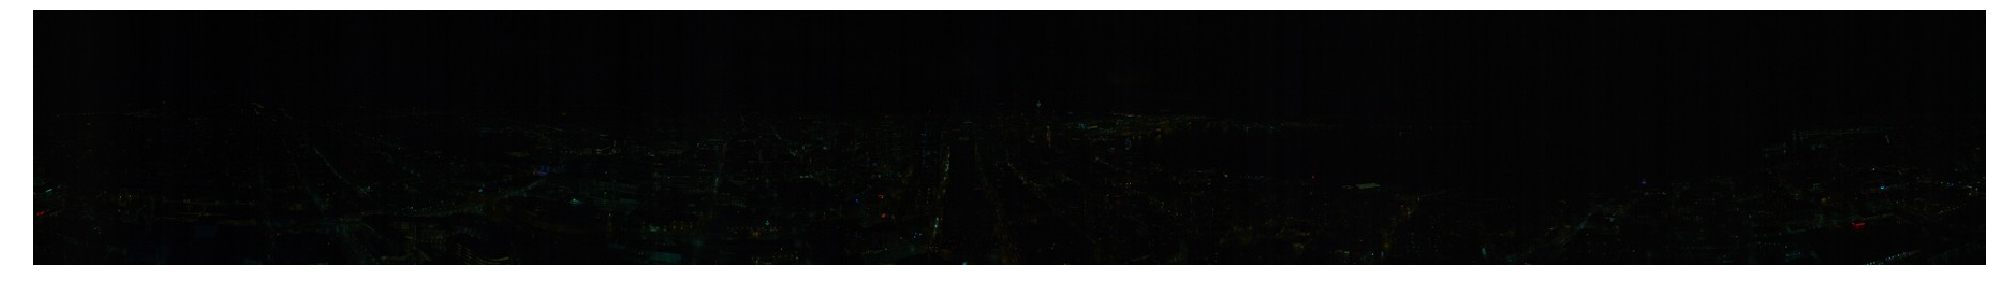

In [3]:
# Helper functions
record_path = '../data/raw/record.pkl'

@load_or_make(record_path, overwrite='n')
def get_record():
    record = defaultdict(dict)
    return record


def display_images(n, score=1):
    record = get_record()
    scores = sum(v['score'] for k, v in record.items())
    print(f"Records loaded. {scores} out of {len(record.keys())} photos have been labeled stunning.")
    l = list(record.keys())

    n_files = []
    while len(n_files) < n:
        f = random.choice(l)
        if record[f]['score'] == score:
            n_files.append(f)

    print(f"\nDisplaying images scored {score}:")
    print(n_files)
    fig = plt.figure(figsize=(35, 12))
    for i, file in enumerate(n_files):
        obj = bucket.Object(file)
        tmp = tempfile.NamedTemporaryFile()
        with open(tmp.name, 'wb') as f:
            obj.download_fileobj(f)
            img=mpimg.imread(tmp.name)
        ax = fig.add_subplot(n, 1, i + 1) 
        ax.imshow(img)
        ax.axis('off')
    plt.subplots_adjust(wspace=0, hspace=0)
    # plt.show()
    return img
n = 1
img = display_images(n, 0)

# Prep Data

In [4]:
import boto3
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler


s3_client = boto3.client('s3')
s3_resource = boto3.resource('s3')

def clean_data(data):
    record = get_record()
    local_files = os.listdir("../data/imgs/")
    bad_files = []
    for file in data['filename']:
        im = Image.open('../data/imgs/' + file)
        shape = np.array(im).shape
        if shape != (237, 1820, 3):
            bad_files.append(file)
            print(f'{file} is wrong shape! Deleting!')
    for file in bad_files:
        record.pop(data[data.filename == file]['filepath'][0], None)
        if os.path.exists(file):
            os.remove(file)
        data = data[data['filename'] != file]
    save_to(record, record_path)
    save_to(data, '../data/interim/clean_data.pkl')
    return data
    
    
def download_from_s3(prefix, local_path, bucket=bucket_name, client=s3_client, resource=s3_resource):
    keys = []
    dirs = []
    next_token = ''
    base_kwargs = {
        'Bucket': bucket_name,
        'Prefix': prefix,
    }
    while next_token is not None:
        kwargs = base_kwargs.copy()
        if next_token != '':
            kwargs.update({'ContinuationToken': next_token})
        results = s3_client.list_objects_v2(**kwargs)
        contents = results.get('Contents')
        for i in contents:
            k = i.get('Key')
            if k[-1] != '/':
                keys.append(k)
            else:
                dirs.append(k)
        next_token = results.get('NextContinuationToken')
    for d in dirs:
        dest_pathname = os.path.join(local, d)
        if not os.path.exists(os.path.dirname(dest_pathname)):
            os.makedirs(os.path.dirname(dest_pathname))
    for k in keys:
        if not os.path.exists(os.path.dirname(local_path)):
            os.makedirs(os.path.dirname(local_path))
        resource.meta.client.download_file(bucket, k, local_path)
    return


def get_files(data, path):
    local_files = set(os.listdir("../data/imgs/"))
    target_files = set(data['filename'])
    missing = target_files.difference(local_files)
    needed = data[data['filename'].isin(missing)]
    
    new_files = 0
    if len(needed) > 0:
        print(f'Getting {len(missing)} files from S3...')
        needed.apply(lambda x: download_from_s3(x['filepath'], path + x['filename']), axis=1)
        print('Success!\n')
        new_files = 1
        
    return new_files


def process_df(df):
    parse = lambda x: ''.join(x.split('/')[3].split('_'))[:-2]
    date_strings = df['index'].apply(parse)
    filenames = date_strings + 'thumb.jpg'
    df['filename'] = filenames

    df['date'] = pd.to_datetime(date_strings, format='%Y%m%d%H%M', errors='ignore')
    df = df.set_index(pd.DatetimeIndex(df['date'])).drop('date', axis=1)
    df = df.rename(columns={'index': 'filepath'})
    save_to(df, '../data/interim/data.pkl')
    
    df['target'] = df.apply(lambda x: ['fine', 'beautiful'][x['score'] > 1], axis=1)
    
    scores = [v / len(data) for k, v in counts.items()]
    cum_scores = {k: (sum(scores[:k]) + scores[k] / 2) for k in counts}
    reg_map = lambda x: cum_scores[x['score']]
    df['reg_score'] = df.apply(reg_map, axis=1)
    
#     df = pd.concat((df, pd.get_dummies(df['target'])), axis=1)
    return df


def get_df_from_record():
    record = get_record()
    df = pd.DataFrame.from_dict(record, orient='index').reset_index().sort_values(by='index')
    save_to(df, '../data/raw/df.pkl')
    return df


def run(balanced=False):
    path = '../data/imgs/'
    if 'imgs' not in os.listdir('../data/'):
        os.mkdir('../data/imgs')
    
    df = get_df_from_record()
    data = process_df(df)
    new_files = get_files(data, path)
#     if new_files:
    data = clean_data(data)
        
    train, test = train_test_split(data, test_size=0.2, random_state=42)
    train, val = train_test_split(train, test_size=0.2, random_state=42)
    if balanced:
        print('\nOversampling minority class.')
        X = train.drop(columns='target')
        y = train['target']
        print(f'Original dataset shape:\n {train.target.value_counts()}')

        ros = RandomOverSampler(random_state=42)
        X_res, y_res = ros.fit_resample(X, y)
        
        
        train = pd.DataFrame(X_res, columns=X.columns)
        train['target'] = y_res
        print(f'Resampled dataset shape:\n {train.target.value_counts()}\n')
    
    
    save_to(train, '../data/processed/train.pkl')
    save_to(val, '../data/processed/val.pkl')
    save_to(test, '../data/processed/test.pkl')
    
    proportion = lambda x: x['target'].value_counts()['beautiful'] / len(x)
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return data

In [54]:
data = run()
data.head()

Saved file to ../data/raw/df.pkl
Saved file to ../data/interim/data.pkl
Saved file to ../data/raw/record.pkl
Saved file to ../data/interim/clean_data.pkl
Saved file to ../data/processed/train.pkl
Saved file to ../data/processed/val.pkl
Saved file to ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.



,filepath,score,matches,local,filename,target,reg_score
date,,,,,,,
2015-01-04 06:30:00,2015/01/04/2015_0104_063000/thumbnail.jpg,0,2,201501040630thumb.jpg,201501040630thumb.jpg,fine,0.288049
2015-01-04 06:40:00,2015/01/04/2015_0104_064000/thumbnail.jpg,0,2,201501040640thumb.jpg,201501040640thumb.jpg,fine,0.288049
2015-01-05 13:10:00,2015/01/05/2015_0105_131000/thumbnail.jpg,0,2,201501051310thumb.jpg,201501051310thumb.jpg,fine,0.288049
2015-01-06 06:00:00,2015/01/06/2015_0106_060000/thumbnail.jpg,0,2,201501060600thumb.jpg,201501060600thumb.jpg,fine,0.288049
2015-01-07 00:20:00,2015/01/07/2015_0107_002000/thumbnail.jpg,0,2,201501070020thumb.jpg,201501070020thumb.jpg,fine,0.288049


## Extract features from convolutional base

We want to use a solution based on pre-trained models. We will use models that are composed of two parts:

* Convolutional base.
* Classifier.

Our approach will use the convolutional base to extract features, using them to train a classifier to classify the input image as beautiful or not. Therefore, the features extracted from the convolutional base will be the same for all classifiers studied in this example.

Now let's see how to extract features from a convolutional base.

In [5]:
# Imports
import os, shutil, sys
from time import time
import matplotlib.pyplot as plt

from keras.layers import *
from keras.optimizers import *
from keras.applications import *
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.applications.imagenet_utils import decode_predictions
from keras import backend as K

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.applications.xception import Xception

import tensorflow as tf

Using TensorFlow backend.


In [6]:
K.clear_session()

In [6]:
def visualize_training(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    return

    
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
    

def get_datagen(data, set_name, img_height, img_width, batch_size):
    datagen = ImageDataGenerator(rescale=1. / 255)
    generator = datagen.flow_from_dataframe(
        dataframe=data,
        directory='../data/imgs/', 
        x_col='filename', 
        y_col='reg_score', 
        target_size=(img_height, img_width),
        class_mode='other', 
        batch_size=batch_size,
        drop_duplicates=False)
    return generator


def extract_features(img_height, img_width, conv_base, model_name, 
                     optimizer, lr, train_layers, batch_size=32):
    # Params
    nb_epoch = 50
    base_model_last_block_layer_number = train_layers # based on number of layers in base model (was 126)
    
    # Top Model Block
    params = f'reg_{base_model_last_block_layer_number}_'
    x = conv_base.output
    x = GlobalAveragePooling2D()(x)
    if True:
        rate = 0.6
        x = Dropout(rate=rate)(x)
        params += f'drop{rate}_'
    if False:
        nodes = 1024
        act = 'relu'
        x = Dense(nodes, activation=act)(x)
        params += f'dense{nodes}{act}_'
    if False:
        rate = 0.4
        x = Dropout(rate=rate)(x)
        params += f'drop{rate}_'
    
    # The Output Layer :
    predictions = (Dense(1, activation='linear'))(x)

    # Combine the network :
    model = Model(conv_base.input, predictions)

    # Visualize layer names and layer indices to see how many layers/blocks to re-train
    # uncomment when choosing based_model_last_block_layer
#     print('Visualizing layer names and indices to see how many layers/blocks to re-train.\n Use to choose base model last block layer.')
#     for i, layer in enumerate(model.layers):
#         print(i, layer.name)

    layer_offset = 0
    if model_name == 'xception':
        layer_offset = 20
    for layer in model.layers[:base_model_last_block_layer_number + layer_offset]:
        layer.trainable = False
    for layer in model.layers[base_model_last_block_layer_number + layer_offset:]:
        layer.trainable = True
    
    # Read data and get generators
    train, val, test = get_data()

    train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
    val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)
    
    decay = 0
    if optimizer == 'sgd':
        lr = lr  # sgd learning rate
        momentum = .9  # sgd momentum to avoid local minimum
        opt = SGD(lr=lr, momentum=momentum, decay=decay, nesterov=False, clipvalue=0.5)
        if decay > 0:
            params += f'{optimizer}-{lr}-decay{decay}_'
        else:
            params += f'{optimizer}-{lr}_'
    elif optimizer == 'rmsprop':
        lr = lr
        opt = RMSprop(lr=lr)
        params += f'{optimizer}-{lr}_'
    else:
        opt = optimizer
        params += f'{optimizer}'
        
    model.compile(opt,
                  loss='mean_squared_error',
                  metrics=[root_mean_squared_error], 
                 )

    # Save weights of best training epoch: monitor either val_loss or val_acc
    model_path = f'../models/{model_name}_{params}/'
    if os.path.isdir(model_path):
        params += '2'
        model_path = f'../models/{model_name}_{params}/'
    os.makedirs(model_path, exist_ok=True)
    top_weights_path = f'{model_path}top_model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(top_weights_path, monitor='val_loss', mode='auto', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=3, verbose=0)
    ]
    
    # Coarse train the top layers
    print_params = ' '.join(params.split('_'))
    print(f'Running model with params: {print_params}')
    model.fit_generator(train_generator,
        steps_per_epoch=np.ceil(len(train) / batch_size),
        epochs=nb_epoch / 10,
        validation_data=val_generator,
        validation_steps=np.ceil(len(val) / batch_size),
        verbose=1,
        callbacks=callbacks_list,
        use_multiprocessing=True
       )
    
    
    # Fine-tune the model
    print(f'\nStarting to fine tune model. Training back to layer {base_model_last_block_layer_number}\n')
    model.load_weights(top_weights_path)

    for layer in model.layers[:base_model_last_block_layer_number]:
        layer.trainable = False
    for layer in model.layers[base_model_last_block_layer_number:]:
        layer.trainable = True

    # Recompile with potential changes
    model.compile(opt,
                  loss='mean_squared_error',
                  metrics=[root_mean_squared_error], 
                 )
    
    # Start up Tensorboard for visualization
    logs_path = f'../models/logs/{model_name}/{params}/'
    
    os.makedirs(logs_path, exist_ok=True)
    print('\nStarting Tensorboard: run the following in terminal:')
    print(f'\ttensorboard --logdir={model_path}logs/\n')
    tensorboard = TensorBoard(log_dir=logs_path)

    # Save weights of best training epoch: monitor either val_loss or val_acc
    final_weights_path = f'{model_path}model_weights.h5'
    callbacks_list = [
        ModelCheckpoint(final_weights_path, monitor='val_loss', mode='auto', verbose=2, save_best_only=True),
        EarlyStopping(monitor='val_loss', patience=8, verbose=1),
        tensorboard
    ]
    
    # Save model
    model_json = model.to_json()
    with open(f'{model_path}model.json', 'w') as json_file:
        json_file.write(model_json)
    print(f'Model written to {model_path}model.json')
    
    history = model.fit_generator(train_generator,
        steps_per_epoch=np.ceil(len(train) / batch_size),
        epochs=nb_epoch,
        validation_data=val_generator,
        validation_steps=np.ceil(len(val) / batch_size),
        verbose=1,
        callbacks=callbacks_list,
        use_multiprocessing=True
       )
    
    save_to(history, f'{model_path}history.pkl')
    return history


def get_data():
    train = load_from('../data/processed/train.pkl')
    val = load_from('../data/processed/val.pkl')
    test = load_from('../data/processed/test.pkl')

    proportion = lambda x: x['target'].value_counts()['beautiful'] / len(x)
    msg = lambda x: f'{x.shape[0]} images with {round(100 * proportion(x), 2)}% positive class.'
    print(f'\nTrain set has {msg(train)}')
    print(f'Val set has {msg(val)}')
    print(f'Test set has {msg(test)}\n')
    
    return (train, val, test)


def get_model(model_name, img_height, img_width):
    if model_name == 'xception':
        conv_base = Xception(
            weights='imagenet', 
            include_top=False, 
            input_shape=(img_height, img_width, 3)
        )
     
    elif model_name == 'inception':
        conv_base = InceptionV3(
            weights='imagenet', 
            include_top=False,
            input_shape=(img_height, img_width, 3)
        )
    
    elif model_name == 'vgg':
        conv_base = VGG16(
            weights='imagenet', 
            include_top=False,
            input_shape=(img_width, img_height, 3)
        )
    
    return conv_base


def train_and_predict(model_name, optimizer, lr, train_layers):
    img_height, img_width = (237, 1820)
    conv_base = get_model(model_name, img_height, img_width)
    history = extract_features(img_height, img_width, 
                               conv_base, model_name, 
                               optimizer, lr, train_layers)
    visualize_training(history)
    return 


def run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=106):
    K.clear_session()
    train_and_predict(model_name, optimizer, lr, train_layers)
    return 

    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 rmsprop-0.0003 2
Instructions for updating:
Use tf.cast instead.
Epoch 1/5
65/65 [==============================] - 301s 5s/step - loss: 0.0600 - root_mean_squared_error: 0.2274 - val_loss: 0.0949 - val_root_mean_squared_error: 0.3058

Epoch 00001: val_loss improved from inf to 0.09492, saving model to ../models/xception_reg_96_drop0.6_rmsprop-0.0003_2/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 284s 4s/step - loss

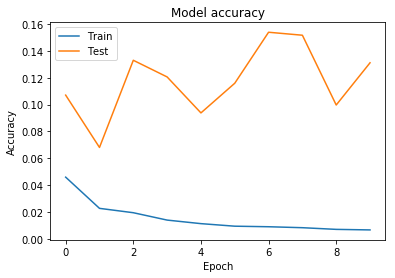

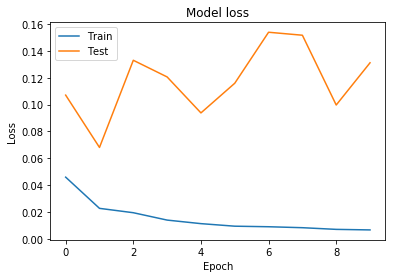

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 rmsprop-0.0001 
Epoch 1/5
65/65 [==============================] - 289s 4s/step - loss: 0.0534 - root_mean_squared_error: 0.2172 - val_loss: 0.1101 - val_root_mean_squared_error: 0.3298

Epoch 00001: val_loss improved from inf to 0.11006, saving model to ../models/xception_reg_96_drop0.6_rmsprop-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 283s 4s/step - loss: 0.0298 - root_mean_squared_error: 0.1655 - val_loss: 0.0524 - val_root_mean_squared_error: 0.2278

Epoch 00002: val_loss improved from 0.11006 to 0.05237, saving model to ../models/xception_reg_96_drop0.6_rmsprop-0.0001_/top_model_weig

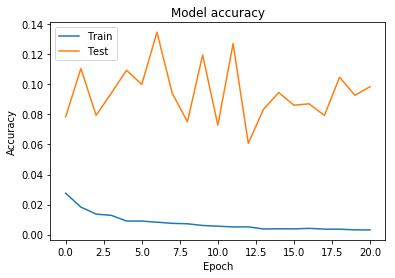

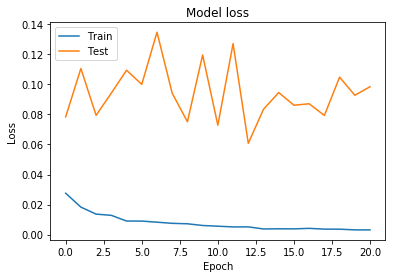

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 rmsprop-0.001 
Epoch 1/5
65/65 [==============================] - 264s 4s/step - loss: 0.1326 - root_mean_squared_error: 0.2767 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2152

Epoch 00001: val_loss improved from inf to 0.04684, saving model to ../models/xception_reg_106_drop0.6_rmsprop-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 259s 4s/step - loss: 0.0364 - root_mean_squared_error: 0.1839 - val_loss: 0.0539 - val_root_mean_squared_error: 0.2308

Epoch 00002: val_loss did not improve from 0.04684
Epoch 3/5
65/65 [==============================] - 259s 4s/step - loss: 0.0251 - root

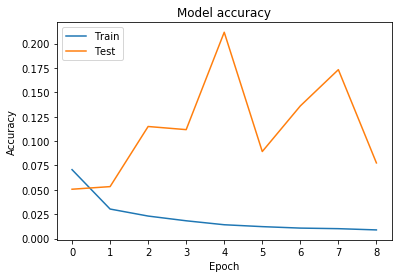

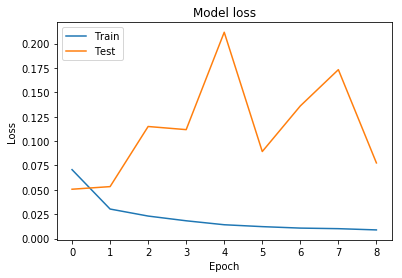

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 rmsprop-0.0003 2
Epoch 1/5
65/65 [==============================] - 264s 4s/step - loss: 0.0762 - root_mean_squared_error: 0.2613 - val_loss: 0.0745 - val_root_mean_squared_error: 0.2708

Epoch 00001: val_loss improved from inf to 0.07451, saving model to ../models/xception_reg_106_drop0.6_rmsprop-0.0003_2/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 258s 4s/step - loss: 0.0303 - root_mean_squared_error: 0.1703 - val_loss: 0.0423 - val_root_mean_squared_error: 0.2050

Epoch 00002: val_loss improved from 0.07451 to 0.04232, saving model to ../models/xception_reg_106_drop0.6_rmsprop-0.0003_2/top_mode

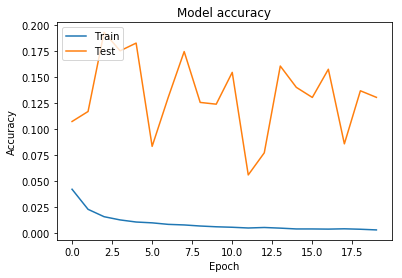

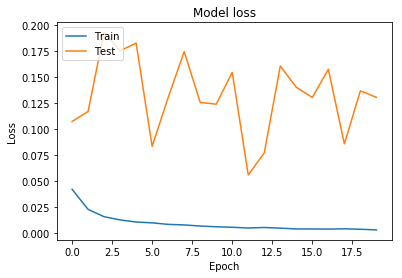

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 rmsprop-0.0001 
Epoch 1/5
65/65 [==============================] - 264s 4s/step - loss: 0.1030 - root_mean_squared_error: 0.3150 - val_loss: 0.0529 - val_root_mean_squared_error: 0.2291

Epoch 00001: val_loss improved from inf to 0.05289, saving model to ../models/xception_reg_106_drop0.6_rmsprop-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 259s 4s/step - loss: 0.0663 - root_mean_squared_error: 0.2551 - val_loss: 0.0514 - val_root_mean_squared_error: 0.2255

Epoch 00002: val_loss improved from 0.05289 to 0.05142, saving model to ../models/xception_reg_106_drop0.6_rmsprop-0.0001_/top_model_w

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [7]:
run(model_name='xception', optimizer='rmsprop', lr=3e-4, train_layers=96)
run(model_name='xception', optimizer='rmsprop', lr=1e-4, train_layers=96)
run(model_name='xception', optimizer='rmsprop', lr=1e-3, train_layers=106)
run(model_name='xception', optimizer='rmsprop', lr=3e-4, train_layers=106)
run(model_name='xception', optimizer='rmsprop', lr=1e-4, train_layers=106)


Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 287s 4s/step - loss: 0.2049 - root_mean_squared_error: 0.4397 - val_loss: 0.1541 - val_root_mean_squared_error: 0.3904

Epoch 00001: val_loss improved from inf to 0.15414, saving model to ../models/xception_reg_96_drop0.6_sgd-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 283s 4s/step - loss: 0.1358 - root_mean_squared_error: 0.3659 - val_loss: 0.1694 - val_root_mean_squared_error: 0.4108

Epoch 00002: val_loss did not improve from 0.15414
Epoch 3/5
65/65 [==============================] - 283s 4s/step - loss: 0.1219 - root_mean_sq

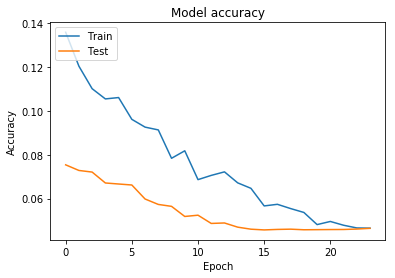

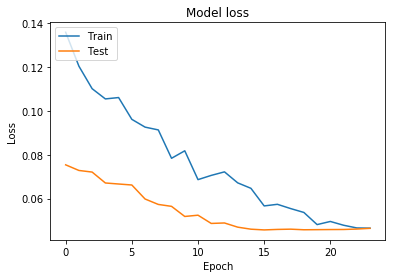

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 rmsprop
Epoch 1/5
65/65 [==============================] - 290s 4s/step - loss: 0.1433 - root_mean_squared_error: 0.3417 - val_loss: 0.0928 - val_root_mean_squared_error: 0.3032

Epoch 00001: val_loss improved from inf to 0.09282, saving model to ../models/xception_reg_96_drop0.6_rmsprop/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 284s 4s/step - loss: 0.0332 - root_mean_squared_error: 0.1776 - val_loss: 0.0588 - val_root_mean_squared_error: 0.2413

Epoch 00002: val_loss improved from 0.09282 to 0.05878, saving model to ../models/xception_reg_96_drop0.6_rmsprop/top_model_weights.h5
Epoch 3/5
65/65 [

Process ForkPoolWorker-46:
Process ForkPoolWorker-45:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 216, in recv_bytes
    buf = self._recv_bytes(maxlength)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [75]:
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=96) # First regression run
run(model_name='xception', optimizer='rmsprop', lr=1e-3, train_layers=96) # First regression run


Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 sgd-0.001 2
Epoch 1/5
65/65 [==============================] - 263s 4s/step - loss: 0.1443 - root_mean_squared_error: 0.3736 - val_loss: 0.1143 - val_root_mean_squared_error: 0.3368

Epoch 00001: val_loss improved from inf to 0.11434, saving model to ../models/xception_reg_106_drop0.6_sgd-0.001_2/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 259s 4s/step - loss: 0.0946 - root_mean_squared_error: 0.3047 - val_loss: 0.0777 - val_root_mean_squared_error: 0.2777

Epoch 00002: val_loss improved from 0.11434 to 0.07768, saving model to ../models/xception_reg_106_drop0.6_sgd-0.001_2/top_model_weights.h5
Ep

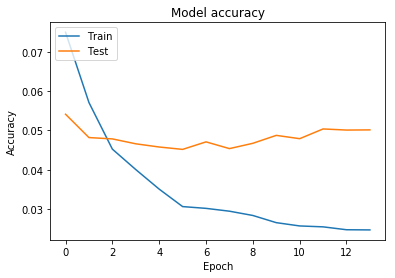

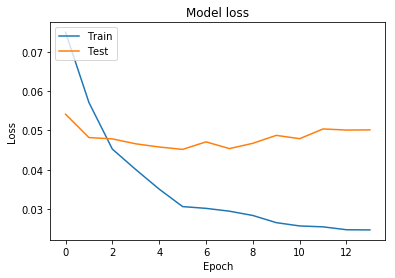

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 sgd-0.001 
Epoch 1/5
65/65 [==============================] - 286s 4s/step - loss: 0.1335 - root_mean_squared_error: 0.3571 - val_loss: 0.1341 - val_root_mean_squared_error: 0.3647

Epoch 00001: val_loss improved from inf to 0.13410, saving model to ../models/xception_reg_96_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 281s 4s/step - loss: 0.0842 - root_mean_squared_error: 0.2876 - val_loss: 0.1259 - val_root_mean_squared_error: 0.3538

Epoch 00002: val_loss improved from 0.13410 to 0.12585, saving model to ../models/xception_reg_96_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch 3/

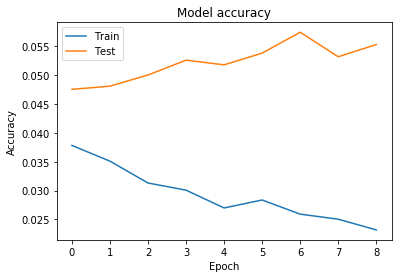

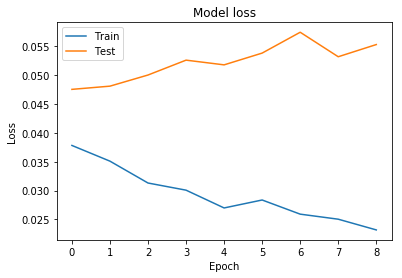

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 sgd-0.0003 
Epoch 1/5
65/65 [==============================] - 286s 4s/step - loss: 0.1674 - root_mean_squared_error: 0.3993 - val_loss: 0.2136 - val_root_mean_squared_error: 0.4612

Epoch 00001: val_loss improved from inf to 0.21364, saving model to ../models/xception_reg_96_drop0.6_sgd-0.0003_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 281s 4s/step - loss: 0.1092 - root_mean_squared_error: 0.3278 - val_loss: 0.1678 - val_root_mean_squared_error: 0.4078

Epoch 00002: val_loss improved from 0.21364 to 0.16776, saving model to ../models/xception_reg_96_drop0.6_sgd-0.0003_/top_model_weights.h5
Epoch

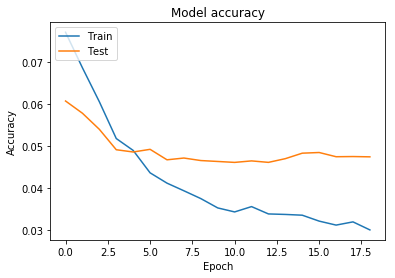

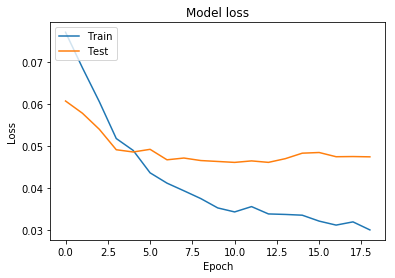

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 96 drop0.6 sgd-0.004 
Epoch 1/5
65/65 [==============================] - 289s 4s/step - loss: 0.0957 - root_mean_squared_error: 0.2995 - val_loss: 0.0723 - val_root_mean_squared_error: 0.2672

Epoch 00001: val_loss improved from inf to 0.07232, saving model to ../models/xception_reg_96_drop0.6_sgd-0.004_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 282s 4s/step - loss: 0.0418 - root_mean_squared_error: 0.2010 - val_loss: 0.0498 - val_root_mean_squared_error: 0.2223

Epoch 00002: val_loss improved from 0.07232 to 0.04981, saving model to ../models/xception_reg_96_drop0.6_sgd-0.004_/top_model_weights.h5
Epoch 3/

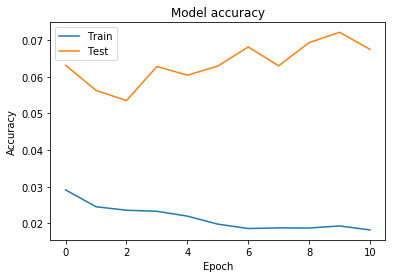

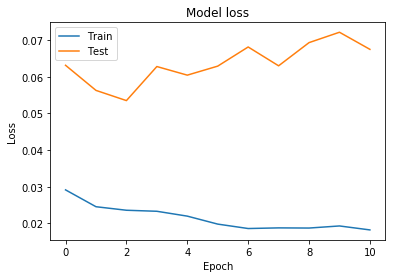

In [74]:
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=106) # First regression run
run(model_name='xception', optimizer='sgd', lr=1e-3, train_layers=96) # First regression run
run(model_name='xception', optimizer='sgd', lr=3e-4, train_layers=96) # First regression run
run(model_name='xception', optimizer='sgd', lr=4e-3, train_layers=96) # First regression run

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 sgd-0.0001 
Epoch 1/5
65/65 [==============================] - 269s 4s/step - loss: 0.1781 - root_mean_squared_error: 0.4127 - val_loss: 0.1332 - val_root_mean_squared_error: 0.3633

Epoch 00001: val_loss improved from inf to 0.13324, saving model to ../models/xception_reg_106_drop0.6_sgd-0.0001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 258s 4s/step - loss: 0.1281 - root_mean_squared_error: 0.3550 - val_loss: 0.1133 - val_root_mean_squared_error: 0.3350

Epoch 00002: val_loss improved from 0.13324 to 0.11328, saving model to ../models/xception_reg_106_drop0.6_sgd-0.0001_/top_model_weights.h5
Ep


Epoch 00020: val_loss improved from 0.07169 to 0.07053, saving model to ../models/xception_reg_106_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 21/50
65/65 [==============================] - 318s 5s/step - loss: 0.0549 - root_mean_squared_error: 0.2324 - val_loss: 0.0708 - val_root_mean_squared_error: 0.2639

Epoch 00021: val_loss did not improve from 0.07053
Epoch 22/50
65/65 [==============================] - 317s 5s/step - loss: 0.0530 - root_mean_squared_error: 0.2281 - val_loss: 0.0693 - val_root_mean_squared_error: 0.2618

Epoch 00022: val_loss improved from 0.07053 to 0.06927, saving model to ../models/xception_reg_106_drop0.6_sgd-0.0001_/model_weights.h5
Epoch 23/50
65/65 [==============================] - 317s 5s/step - loss: 0.0547 - root_mean_squared_error: 0.2309 - val_loss: 0.0700 - val_root_mean_squared_error: 0.2635

Epoch 00023: val_loss did not improve from 0.06927
Epoch 24/50
65/65 [==============================] - 316s 5s/step - loss: 0.0508 - root_mean_squared_error

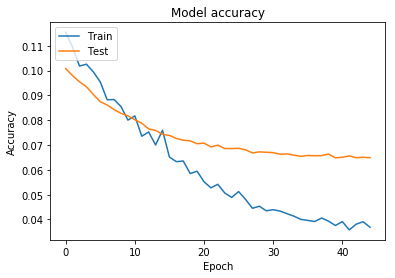

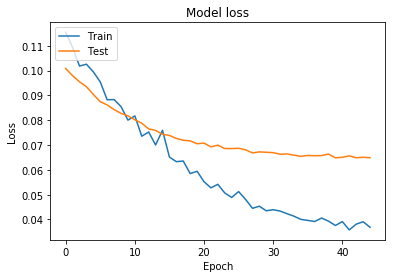

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 sgd-0.001 
Epoch 1/5
65/65 [==============================] - 265s 4s/step - loss: 0.1406 - root_mean_squared_error: 0.3685 - val_loss: 0.0667 - val_root_mean_squared_error: 0.2572

Epoch 00001: val_loss improved from inf to 0.06669, saving model to ../models/xception_reg_106_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 259s 4s/step - loss: 0.1005 - root_mean_squared_error: 0.3149 - val_loss: 0.0532 - val_root_mean_squared_error: 0.2297

Epoch 00002: val_loss improved from 0.06669 to 0.05317, saving model to ../models/xception_reg_106_drop0.6_sgd-0.001_/top_model_weights.h5
Epoch

Process ForkPoolWorker-20:
Process ForkPoolWorker-19:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/home/ubuntu/anaconda3/envs/tensor

  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
KeyboardInterrupt


KeyboardInterrupt: 

In [72]:
run(model_name='xception', optimizer='sgd', lr=1e-4, train_layers=106) # First regression run


In [70]:
run(model_name='xception', optimizer='sgd', lr=3e-4, train_layers=106) # First regression run

Loaded file from ../data/processed/train.pkl
Loaded file from ../data/processed/val.pkl
Loaded file from ../data/processed/test.pkl

Train set has 2056 images with 4.82% positive class.
Val set has 514 images with 6.03% positive class.
Test set has 643 images with 5.29% positive class.

Found 2056 images.
Found 514 images.
Running model with params: reg 106 drop0.6 sgd-0.0003 2
Epoch 1/5
65/65 [==============================] - 271s 4s/step - loss: 0.1760 - root_mean_squared_error: 0.4134 - val_loss: 0.0655 - val_root_mean_squared_error: 0.2546

Epoch 00001: val_loss improved from inf to 0.06546, saving model to ../models/xception_reg_106_drop0.6_sgd-0.0003_2/top_model_weights.h5
Epoch 2/5
65/65 [==============================] - 258s 4s/step - loss: 0.1218 - root_mean_squared_error: 0.3469 - val_loss: 0.0658 - val_root_mean_squared_error: 0.2547

Epoch 00002: val_loss did not improve from 0.06546
Epoch 3/5
65/65 [==============================] - 259s 4s/step - loss: 0.1089 - root_mea

KeyError: 'acc'

# Interpreting Results

In [5]:
from keras.models import model_from_json

def load_model(name):
    model_path = f'../models/{name}/'

    # Model reconstruction from JSON file
    with open(model_path + 'model.json', 'r') as f:
        model = model_from_json(f.read())

    # Load weights into the new model
    model.load_weights(model_path + 'model_weights.h5')
    return model

Using TensorFlow backend.


In [6]:
model = load_model('xception')

Instructions for updating:
Colocations handled automatically by placer.


In [51]:
img_height, img_width = (237, 1820)
batch_size = 32

train, val, test = get_data()

train_generator = get_datagen(train, 'train', img_height, img_width, batch_size)
val_generator = get_datagen(val, 'val', img_height, img_width, batch_size)

# callbacks_list = [
#     ModelCheckpoint(final_weights_path, monitor='val_acc', verbose=2, save_best_only=True),
#     EarlyStopping(monitor='val_loss', patience=5, verbose=0)
# ]

Loaded file from ../data/interim/train.pkl
Loaded file from ../data/interim/val.pkl
Loaded file from ../data/interim/test.pkl

Train set has 1878 images with 22.74% positive class.
Val set has 470 images with 22.77% positive class.
Test set has 588 images with 21.43% positive class.

Found 1878 images belonging to 2 classes.
Found 470 images belonging to 2 classes.


In [31]:
train_generator.reset()
predictions = model.predict_generator(train_generator, 
                                      steps=np.ceil(len(train) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

48/48 [==============================] - 151s 3s/step


1.0    1530
Name: 0, dtype: int64

In [23]:
predictions = model.predict_generator(val_generator, 
                                      steps=np.ceil(len(val) / batch_size),
                                      verbose=1)

pd.DataFrame(predictions)[0].value_counts()

12/12 [==============================] - 37s 3s/step


1.0    383
Name: 0, dtype: int64

In [52]:
train_generator.class_indices

{'beautiful': 0, 'fine': 1}

In [40]:
val_generator.class_indices

{'beautiful': 0, 'fine': 1}